In [266]:
import random
import heapq
import matplotlib.pyplot as plt
import numpy as np

In [267]:
class Event:
    def __init__(self, time, customer_id, assigned_server_id, type):
        self.time = time
        self.customer_id = customer_id
        self.assigned_server_id = assigned_server_id
        self.type = type
    
    def __lt__(self, other):
        return self.time < other.time

In [268]:
class Customer:
    def __init__(self, time, customer_id, assigned_server_id, event_type):
        self.time = time
        self.customer_id = customer_id
        self.assigned_server_id = assigned_server_id
        self.event_type = event_type

In [269]:
class Server:
    def __init__(self, server_id, service_time, is_busy, busy_until, current_load, total_load):
        self.server_id = server_id
        self.service_time = service_time
        self.is_busy = is_busy
        self.busy_until = busy_until
        self.current_load = current_load
        self.total_load = total_load
    
    def __repr__(self):
        return f'({self.server_id}, {self.service_time}, {self.is_busy}, {self.busy_until}, {self.current_load}, {self.total_load})'

In [335]:
class Simulation:
    def __init__(self, arrival_rate, service_rate, num_servers, num_customers):
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        self.num_servers = num_servers
        self.num_customers = num_customers
        self.customers = 0
        self.waiting_queue = []
        self.total_time_spent = 0
        self.max_time_spent = 0
        self.busy_servers = 0 
        self.queue_size = [0]
        self.event_queue = []

    def get_interarrival_time(self):
        return random.expovariate(1.0 / self.arrival_rate)

    def get_service_time(self):
        return random.expovariate(1.0 / self.service_rate)
        
    def run(self, d_choices, scenario, servers_speed):
        
        heapq.heappush(self.event_queue, Event(0, 0, None, 'arrival'))
        interarrival_time = self.get_interarrival_time()

        if servers_speed == 'same': 
            service = self.get_service_time()
            self.servers = [Server(i, service, False, None, 0, 0) for i in range(self.num_servers)]

        elif servers_speed == 'different':
            self.servers = [Server(i, self.get_service_time(), False, None, 0, 0) for i in range(self.num_servers)]

        while self.event_queue:
            
            # time, customer_id, assigned_server_id, type
            event = heapq.heappop(self.event_queue)
            
            if event.type == 'arrival':
                # Handle_arrival
                self.customers += 1

                # Schedule the next customer arrival event
                if self.customers < self.num_customers:
                    heapq.heappush(self.event_queue, Event(event.time + interarrival_time, event.customer_id + 1, None, 'arrival'))

                # Assign customer to server
                if scenario == 'uniform server selection':
                    choosen_server = random.choice(self.servers)

                elif scenario == 'uniform server selection with power of d-choices':
                    d_servers = random.sample(self.servers, d_choices)
                    minimum_load = min(server.current_load for server in d_servers)
                    servers_with_equal_load = [server for server in d_servers if server.current_load == minimum_load]
                                          
                    if servers_speed == 'different':
                        # Take the fastest server from servers with equal load
                        fastest_from_equal_load = [server for server in servers_with_equal_load if server.service_time == min(server.service_time for server in servers_with_equal_load)]
                        choosen_server = fastest_from_equal_load[0]
                    else:
                        choosen_server = random.choice(servers_with_equal_load)
                        # Try choose first from list server_with_equal_load

                choosen_server.current_load += 1
                choosen_server.total_load += 1
                customer = Customer(event.time, event.customer_id, choosen_server.server_id, event.type)

                if not choosen_server.is_busy:
                    # Serve customer immediately start_serving()
                    choosen_server.is_busy = True
                    departure_time = event.time + choosen_server.service_time                    
                    choosen_server.busy_until = departure_time
                    self.total_time_spent += choosen_server.service_time
                    self.max_time_spent = max(self.max_time_spent, choosen_server.service_time)
                    # Schedule the departure event for the customer
                    heapq.heappush(self.event_queue, Event(departure_time, event.customer_id, choosen_server.server_id, 'departure'))
                else:
                    # If the chosen server is busy, add a customer to the waiting queue
                    self.waiting_queue.append(customer)
                    busy_servers = sum(server.is_busy for server in self.servers)
                    self.queue_size.append((len(self.waiting_queue) / busy_servers))  
            
            elif event.type == 'departure':
                # Handle departure 
                server = self.servers[event.assigned_server_id]
                # Free up server
                server.is_busy = False
                server.busy_until = None
                server.current_load -= 1
                # If that server which free's up has assigned for a customer in waiting_queue start serving this customer first on the list
                for waiting_customer in self.waiting_queue:
                    if waiting_customer.assigned_server_id == event.assigned_server_id:
                        server.is_busy = True
                        waiting_time = event.time - waiting_customer.time
                        time_spent = waiting_time + server.service_time
                        self.total_time_spent += time_spent
                        self.max_time_spent = max(self.max_time_spent, time_spent)
                        departure_time = event.time + server.service_time
                        server.busy_until = departure_time
                        # Schedule the departure event for the customer
                        heapq.heappush(self.event_queue, Event(departure_time, event.customer_id, event.assigned_server_id, 'departure'))
                        # Remove customer from the waiting queue
                        self.waiting_queue.remove(waiting_customer)
                        break   

        avg_time_spent = self.total_time_spent / self.customers
        server_utilization = [(server.total_load / self.customers) * 100 for server in self.servers]
        avg_queue_size = np.mean(self.queue_size)

        return avg_time_spent, self.max_time_spent, server_utilization, avg_queue_size

        #print('Average time a customer spends in the system: ', avg_time_spent)
        #print('Max time a customer spends in the system: ', self.max_time_spent)
        #print('Percentage servers utilization: ', server_utilization)
        #print('Average queue size: ', avg_queue_size)


In [312]:
def experiment(d_choices, scenario, servers_speed):
    data = {'avg_time_spent': [], 'max_time_spent': [], 'server_utilization': [], 'avg_queue_size': []}
    for _ in range(0, 10000, 10):
        simulation = Simulation(arrival_rate=0.2, service_rate=0.8, num_servers=100, num_customers=10000)
        avg_time_spent, max_time_spent, server_utilization, avg_queue_size = simulation.run(d_choices, scenario, servers_speed)
        data['avg_time_spent'].append(avg_time_spent)
        data['max_time_spent'].append(max_time_spent)
        data['server_utilization'].append(server_utilization)
        data['avg_queue_size'].append(avg_queue_size)
    return data

In [332]:
def plot(data):
    plt.plot(data['avg_time_spent'])
    plt.plot(data['avg_queue_size'])
    #plt.bar(data['server_utilization'])
    mean_avg_time_spent = np.mean(data['avg_time_spent'])
    mean_avg_queue_size = np.mean(data['avg_queue_size'])

    print('mean_avg_time_spent', mean_avg_time_spent)
    print('mean_avg_queue_size', mean_avg_queue_size)

# Pierwszy scenariusz

### Identyczne serwery i zadania

#### a) jednostajny wybór serwera

mean_avg_time_spent 2.790083133455514
mean_avg_queue_size 1.396794684378052


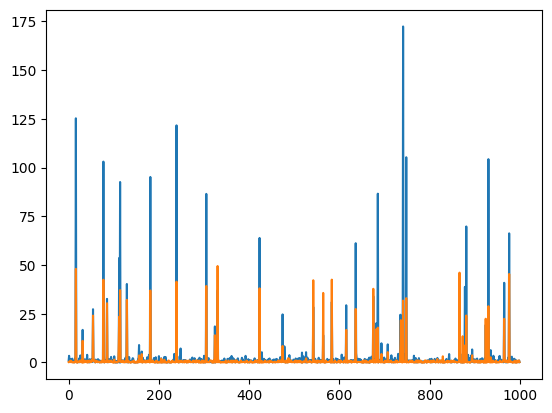

In [299]:
plot(d_choices=False, scenario='uniform server selection', servers_speed='same')

#### b) wybór mniej obciążonego z 2 jednostajnie wybranych serwerów

mean_avg_time_spent 1.94075266271646
mean_avg_queue_size 0.7158111276594156


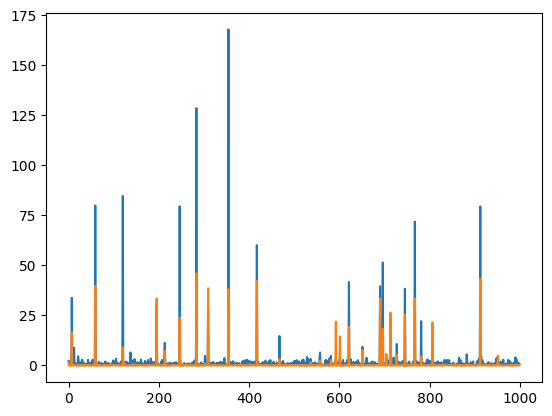

In [300]:
plot(d_choices=2, scenario='uniform server selection with power of d-choices', servers_speed='same')

#### c) wybór mniej obciążonego z d jednostajnie wybranych serwerów

In [306]:
same_speeds_3_choices = experiment(d_choices=3, scenario='uniform server selection with power of d-choices', servers_speed='same')

mean_avg_time_spent 2.1883936599868594
mean_avg_queue_size 1.0004780104574647


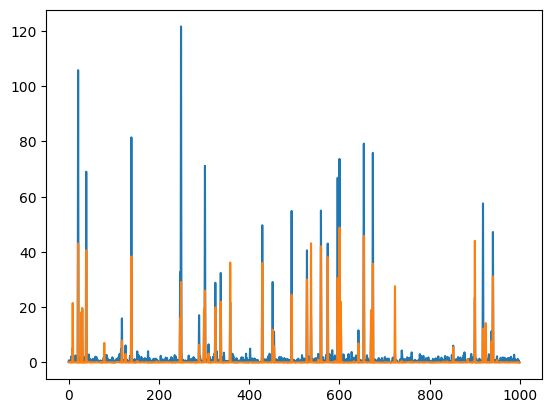

In [307]:
plot(same_speeds_3_choices)

# Drugi scenariusz

### Serwery o różnej szybkości, takie same zadania

#### a) jednostajny wybór serwera

In [ ]:
different_servers_uniform_choice = experiment(d_choices=False, scenario='uniform server selection', servers_speed='different')

mean_avg_time_spent 2.5721575238612258
mean_avg_queue_size 1.882056464671077


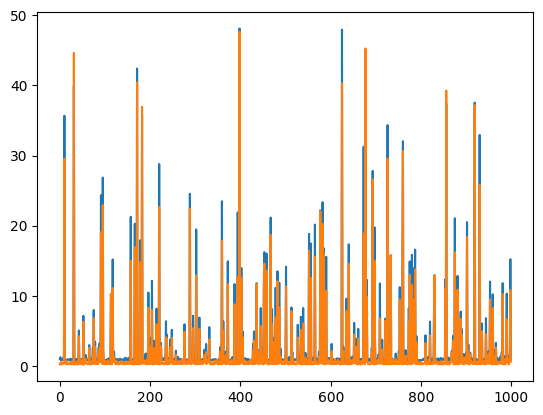

In [309]:
plot(different_servers_uniform_choice)

#### b) wybór mniej obciążonego z 2 jednostajnie wybranych serwerów

In [330]:
different_servers_2_choices = experiment(d_choices=2, scenario='uniform server selection with power of d-choices', servers_speed='different')

mean_avg_time_spent 0.7311838693043273
mean_avg_queue_size 0.6153893307721228


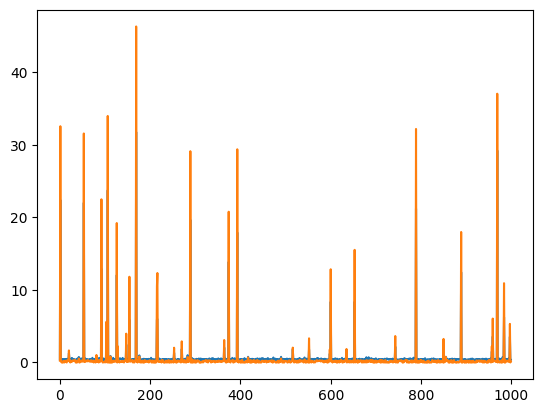

In [331]:
plot(different_servers_2_choices)

#### c) wybór mniej obciążonego z d jednostajnie wybranych serwerów

mean_avg_time_spent 0.41094670807312256
mean_avg_queue_size 0.20623101064012975


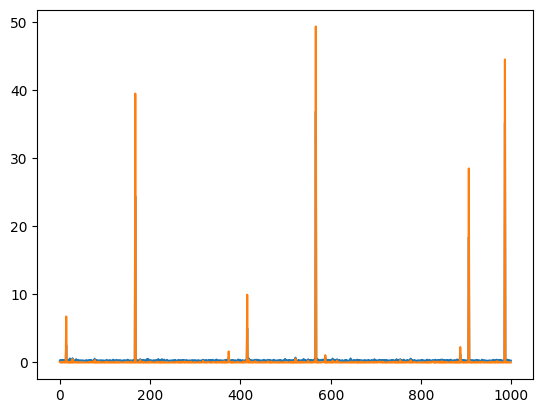

In [334]:
plot(experiment(d_choices=3, scenario='uniform server selection with power of d-choices', servers_speed='different'))

#### d) wybór mniej obciążonego z 2 niejednostajnie wybranych serwerów

#### e) wybór mniej obciążonego z d niejednostajnie wybranych serwerów

# Trzeci scenariusz

### Serwery o różnej szybkości, różne zadania

#### a) jednostajny wybór serwera

#### b) wybór mniej obciążonego z 2 jednostajnie wybranych serwerów

#### c) wybór mniej obciążonego z d jednostajnie wybranych serwerów

#### d) wybór mniej obciążonego z 2 niejednostajnie wybranych serwerów

#### e) wybór mniej obciążonego z d niejednostajnie wybranych serwerów